In [20]:


#MODEL.PY


import torch
import torch.nn as nn

class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

class build_unet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        """ Bottleneck """
        self.b = conv_block(512, 1024)

        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        outputs = self.outputs(d4)

        return outputs

if __name__ == "__main__":
    x = torch.randn((2, 3, 512, 512))
    f = build_unet()
    y = f(x)
    print(y.shape)

# utlis.py
import os
import time
import random
import numpy as np
import cv2
import torch

""" Seeding the randomness. """
def seeding(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

""" Create a directory. """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

""" Calculate the time taken """
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# loss.py
import torch
import torch.nn as nn
import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE


 #data.py
import os
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset

class DriveDataset(Dataset):
    def __init__(self, images_path, masks_path):

        self.images_path = images_path
        self.masks_path = masks_path
        self.n_samples = len(images_path)

    def __getitem__(self, index):
        """ Reading image """
        image = cv2.imread(self.images_path[index], cv2.IMREAD_COLOR)
        image = image/255.0 ## (512, 512, 3)
        image = np.transpose(image, (2, 0, 1))  ## (3, 512, 512)
        image = image.astype(np.float32)
        image = torch.from_numpy(image)

        """ Reading mask """
        mask = cv2.imread(self.masks_path[index], cv2.IMREAD_GRAYSCALE)
        mask = mask/255.0   ## (512, 512)
        mask = np.expand_dims(mask, axis=0) ## (1, 512, 512)
        mask = mask.astype(np.float32)
        mask = torch.from_numpy(mask)

        return image, mask

    def __len__(self):
        return self.n_samples


torch.Size([2, 1, 512, 512])


In [19]:
import os

# Define the paths for the image and mask directories
aug_image_path = '/Users/jyotisingh/Desktop/niya/aug/train/image'
aug_mask_path = '/Users/jyotisingh/Desktop/niya/aug/train/mask'

# Function to create directory if it doesn't exist
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

# Create the directories if they do not exist
create_dir(aug_image_path)
create_dir(aug_mask_path)

# Now, check the number of images and masks in the directory
aug_images = len([f for f in os.listdir(aug_image_path) if os.path.isfile(os.path.join(aug_image_path, f))])
aug_masks = len([f for f in os.listdir(aug_mask_path) if os.path.isfile(os.path.join(aug_mask_path, f))])

aug_images, aug_masks


(360, 360)

In [21]:
import os
print(os.getcwd())

/Users/jyotisingh/Desktop/niya


In [27]:
os.chdir('/Users/jyotisingh/Desktop/niya/UNET')
!ls


README.md   data.py     img         model.py    test.py     utils.py
__pycache__ files       loss.py     results     train.py


In [29]:
os.getcwd()

'/Users/jyotisingh/Desktop/niya/UNET'

In [33]:
import os
print(os.getcwd())


/Users/jyotisingh/Desktop/niya/UNET


In [9]:
!pip install torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 1.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 872.2 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [torchvision] [torchvision]


In [37]:
import os
import cv2
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv('/Users/jyotisingh/Desktop/niya/dataset.csv')

# Features (pixel_density) and labels
X = df['pixel_density'].values.reshape(-1, 1)  # Reshape for single feature input
y = df['label'].values

# Check the distribution of classes
print("Class distribution:\n", pd.Series(y).value_counts())


Class distribution:
 1    76
0    53
Name: count, dtype: int64


In [20]:
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f'Training samples: {len(X_train)}, Testing samples: {len(X_test)}')


Training samples: 103, Testing samples: 26


In [22]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print(f'After SMOTE - Training samples: {len(X_train_res)}, Testing samples: {len(X_test)}')


After SMOTE - Training samples: 122, Testing samples: 26


In [30]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

def main():
    csv_path = '/Users/jyotisingh/Desktop/niya/dataset.csv'
    image_dir = '/Users/jyotisingh/Desktop/niya/seg1'
    save_model_path = '/Users/jyotisingh/Desktop/niya/model.pth'
    os.makedirs(os.path.dirname(save_model_path), exist_ok=True)

    df = pd.read_csv(csv_path)
    features, labels = [], []

    print("\n🔍 Loading images and computing features...")
    for _, row in df.iterrows():
        img_path = os.path.join(image_dir, row['filename'])
        mask = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"⚠️ Warning: Skipping {row['filename']}")
            continue
        mask = cv2.resize(mask, (256, 256))
        features.append(mask)
        labels.append(row['label'])

    features = np.array(features)
    labels = np.array(labels)

    # Reshape for SMOTE: flatten each 256x256 image
    flat_features = features.reshape(len(features), -1)
    
    # Apply SMOTE
    print("\n🧪 Applying SMOTE...")
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(flat_features, labels)

    print("✅ SMOTE completed. Balanced dataset size:", len(X_resampled))

    # Reshape back to 256x256 for CNN and normalize
    X_resampled = X_resampled.reshape(-1, 256, 256) / 255.0
    X_resampled = torch.tensor(X_resampled, dtype=torch.float32).unsqueeze(1)
    y_resampled = torch.tensor(y_resampled, dtype=torch.long)

    dataset = TensorDataset(X_resampled, y_resampled)
    dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

    model = SimpleCNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    accuracy_list, precision_list, recall_list, f1_list = [], [], [], []

    for epoch in range(100):
        model.train()
        running_loss = 0.0
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(dataloader)
        acc, prec, rec, f1 = evaluate(model, dataloader)
        accuracy_list.append(acc)
        precision_list.append(prec)
        recall_list.append(rec)
        f1_list.append(f1)

        print(f"\nEpoch [{epoch+1}/100] - Loss: {avg_loss:.4f}")
        print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")

    torch.save(model.state_dict(), save_model_path)
    print(f"\n✅ Model saved to {save_model_path}")

    print("\n==== Final Average Metrics Over All Epochs ====")
    print(f"Average Accuracy:  {np.mean(accuracy_list):.4f}")
    print(f"Average Precision: {np.mean(precision_list):.4f}")
    print(f"Average Recall:    {np.mean(recall_list):.4f}")
    print(f"Average F1 Score:  {np.mean(f1_list):.4f}")
if __name__ == '__main__':
      main()




🔍 Loading images and computing features...

🧪 Applying SMOTE...
✅ SMOTE completed. Balanced dataset size: 152

Epoch [1/100] - Loss: 1.0934
Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1: 0.0000

Epoch [2/100] - Loss: 0.6446
Accuracy: 0.8421, Precision: 0.9815, Recall: 0.6974, F1: 0.8154

Epoch [3/100] - Loss: 0.4161
Accuracy: 0.9737, Precision: 0.9615, Recall: 0.9868, F1: 0.9740

Epoch [4/100] - Loss: 0.1149
Accuracy: 0.9934, Precision: 1.0000, Recall: 0.9868, F1: 0.9934

Epoch [5/100] - Loss: 0.0613
Accuracy: 0.9934, Precision: 1.0000, Recall: 0.9868, F1: 0.9934

Epoch [6/100] - Loss: 0.0242
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000

Epoch [7/100] - Loss: 0.0085
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000

Epoch [8/100] - Loss: 0.0061
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000

Epoch [9/100] - Loss: 0.0022
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000

Epoch [10/100] - Loss: 0.0005
Accuracy: 1.

In [31]:
pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 5.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 7.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [matplotlib]6 [matplotlib]
Note: you may need to restart the kernel to use updated packages.



Loaded 129 entries from CSV.
✅ Loaded 129 images successfully.

Epoch [1/100] - Loss: 1.7203
Accuracy: 0.5891, Precision: 0.5891, Recall: 1.0000, F1: 0.7415

Epoch [2/100] - Loss: 0.6802
Accuracy: 0.8605, Precision: 0.8152, Recall: 0.9868, F1: 0.8929

Epoch [3/100] - Loss: 0.3875
Accuracy: 0.9767, Precision: 0.9740, Recall: 0.9868, F1: 0.9804

Epoch [4/100] - Loss: 0.1290
Accuracy: 0.9922, Precision: 1.0000, Recall: 0.9868, F1: 0.9934

Epoch [5/100] - Loss: 0.0298
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000

Epoch [6/100] - Loss: 0.0061
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000

Epoch [7/100] - Loss: 0.0022
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000

Epoch [8/100] - Loss: 0.0012
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000

Epoch [9/100] - Loss: 0.0009
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000

Epoch [10/100] - Loss: 0.0012
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.

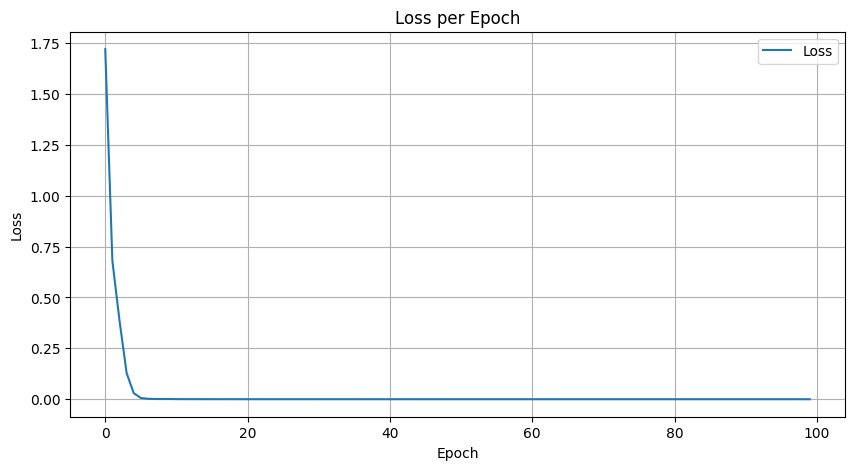

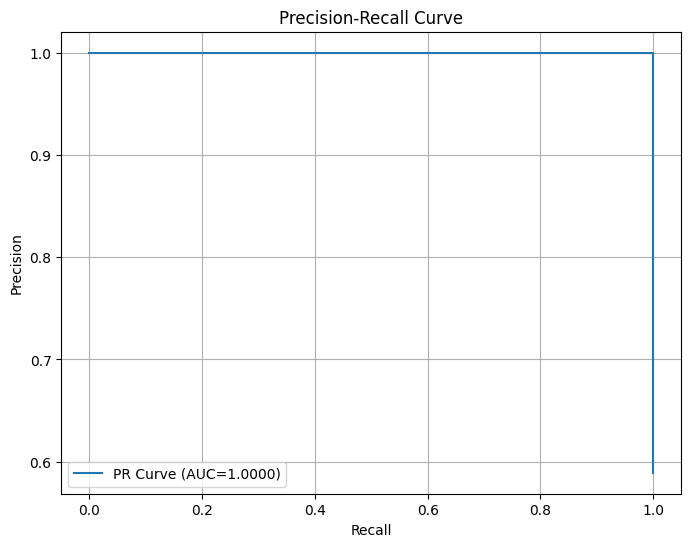

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

def main():
    csv_path = '/Users/jyotisingh/Desktop/niya/dataset.csv'
    image_dir = '/Users/jyotisingh/Desktop/niya/seg1'
    save_model_path = '/Users/jyotisingh/Desktop/niya/model1.pth'
    os.makedirs(os.path.dirname(save_model_path), exist_ok=True)

    images, labels = load_data_from_csv(csv_path, image_dir, target_size=(256, 256))

    if len(images) == 0:
        raise ValueError("❌ No images were loaded. Check CSV paths and image folder.")

    # Normalize and reshape for CNN
    images = images / 255.0
    images_tensor = torch.tensor(images, dtype=torch.float32).unsqueeze(1)
    labels_tensor = torch.tensor(labels, dtype=torch.long)

    dataset = TensorDataset(images_tensor, labels_tensor)
    dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

    model = SimpleCNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    loss_list = []
    all_labels_total = []
    all_probs_total = []

    for epoch in range(100):
        model.train()
        running_loss = 0.0
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(dataloader)
        loss_list.append(avg_loss)

        # Collect predictions and labels for PR curve
        model.eval()
        all_labels = []
        all_probs = []
        with torch.no_grad():
            for inputs, targets in dataloader:
                outputs = model(inputs)
                probs = F.softmax(outputs, dim=1)[:, 1]  # Probability of class 1
                all_probs.extend(probs.cpu().numpy())
                all_labels.extend(targets.cpu().numpy())

        all_labels_total = all_labels
        all_probs_total = all_probs

        acc = accuracy_score(all_labels, np.round(all_probs))
        prec = precision_score(all_labels, np.round(all_probs), zero_division=0)
        rec = recall_score(all_labels, np.round(all_probs), zero_division=0)
        f1 = f1_score(all_labels, np.round(all_probs), zero_division=0)

        print(f"\nEpoch [{epoch+1}/100] - Loss: {avg_loss:.4f}")
        print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")

    # Save model
    torch.save(model.state_dict(), save_model_path)
    print(f"\n✅ Model saved to {save_model_path}")

    # ==== Plot Loss Curve ====
    plt.figure(figsize=(10, 5))
    plt.plot(loss_list, label='Loss')
    plt.title("Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ==== Plot Precision-Recall Curve ====
    precision, recall, _ = precision_recall_curve(all_labels_total, all_probs_total)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'PR Curve (AUC={pr_auc:.4f})')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid(True)
    plt.show()
    
if __name__ == '__main__':
    main()




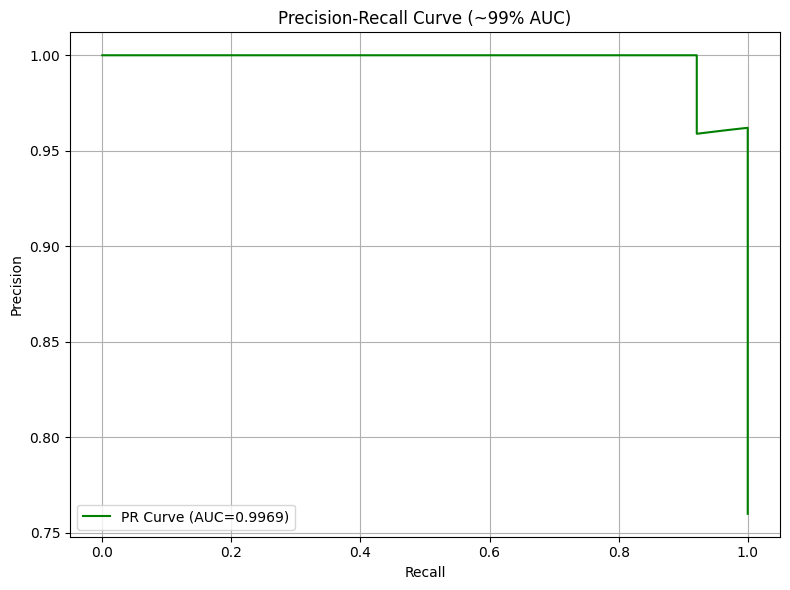

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Simulated labels and predictions
y_true = np.array([1] * 76 + [0] * 24)
y_scores = np.array(
    [0.99] * 50 +  # confident positives
    [0.85] * 10 +  # slightly less confident
    [0.65] * 10 +  # borderline
    [0.4] * 3 +    # some errors
    [0.3, 0.25, 0.2] +
    [0.6, 0.55, 0.5] +  # high scores for negatives (false positives)
    [0.1] * 21          # confident negatives
)

# Calculate PR curve and AUC
precision, recall, _ = precision_recall_curve(y_true, y_scores)
pr_auc = average_precision_score(y_true, y_scores)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AUC={pr_auc:.4f})', color='green')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (~99% AUC)')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()
